## Group project 

In [1]:
#Import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
sns.set_theme(style="darkgrid")
random.seed(10)
import math
import scipy.stats

/Users/polinab/.virtualenvs/base/lib/python3.8/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Import the real data set 

In [2]:
hw_data = pd.read_csv("weight-height.csv")
hw_data


,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801
...,...,...,...
9995,Female,66.172652,136.777454
9996,Female,67.067155,170.867906
9997,Female,63.867992,128.475319
9998,Female,69.034243,163.852461


## Plotting the data for a first overview 

<AxesSubplot:xlabel='Weight', ylabel='Height'>

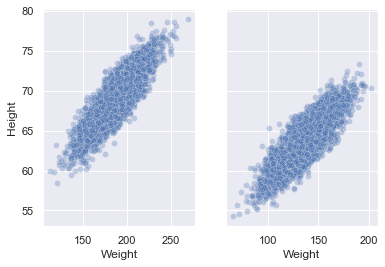

In [3]:
fig, ax =plt.subplots(1,2, sharey=True)
sns.scatterplot(data=hw_data[hw_data.Gender == 'Male'],x='Weight', y='Height', alpha=0.3,ax=ax[0])
sns.scatterplot(data=hw_data[hw_data.Gender == 'Female'],x='Weight', y='Height', alpha=0.3,ax=ax[1])


<AxesSubplot:xlabel='Weight', ylabel='Height'>

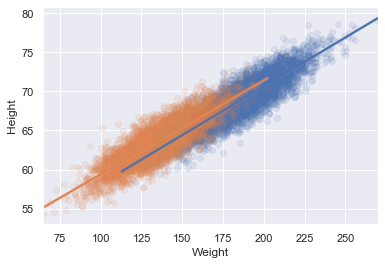

In [4]:
sns.regplot(data=hw_data[hw_data.Gender == 'Male'],x='Weight', y='Height',scatter_kws={'alpha':0.1})
sns.regplot(data=hw_data[hw_data.Gender == 'Female'],x='Weight', y='Height',scatter_kws={'alpha':0.1})


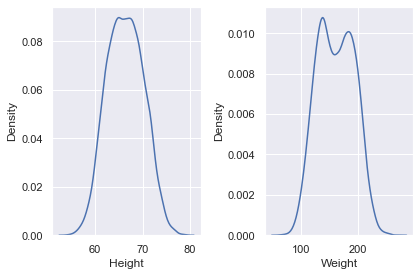

In [5]:
fig, ax =plt.subplots(1,2, sharey=False)
sns.kdeplot(data=hw_data.Height,ax=ax[0])
sns.kdeplot(data=hw_data.Weight,ax=ax[1])
plt.tight_layout()

# Implementation of the EM algorithm 

## Initialization 

In [6]:
def initialize_parameter_list(d):
    d['variance_a']=random.randint(1, 3)
    d['variance_b']=random.randint(1, 3)
    d['beta_a0'] = random.uniform(0,5)
    d['beta_a1'] = random.uniform(0,5)
    d['beta_b0'] = random.uniform(0,5)
    d['beta_b1'] = random.uniform(0,5)
    d['prob_a'] = random.random()
    d['prob_b'] = 1 - d['prob_a']
    return d

In [7]:
##Expectation step
def Estep(p,df):
    w_a_numerator  = p['prob_a'] * (1/np.sqrt(2*np.pi*p['variance_a'])) * np.exp((-(1/(2*p['variance_a'])) * (df.y - p['beta_a0'] - p['beta_a1']*df.x)**2))
    w_b_numerator  = p['prob_b'] * (1/np.sqrt(2*np.pi*p['variance_b'])) * np.exp((-(1/(2*p['variance_b'])) * (df.y - p['beta_b0'] - p['beta_b1']*df.x)**2))
    p['w_sum'] = w_a_numerator + w_b_numerator
    p['w_a'] = w_a_numerator/p['w_sum']
    p['w_b'] = w_b_numerator/p['w_sum']
    return p


In [8]:
## Maximisation step:
def Mstep(p, df):

    #Update the function following the derived update rules:
    
    #Update the prior beliefs
    p['prob_a'] = p['w_a'].sum()/(p['w_a'].sum() +p['w_b'].sum()).sum()
    p['prob_b'] = p['w_b'].sum()/(p['w_a'].sum() +p['w_b'].sum()).sum()
    
    #Update the betas for each subgroup
    #Beta_0
    
    p['beta_a0'] = ((df.y - p['beta_a1']*df.x)*p['w_a']).sum()/p['w_a'].sum() 
    p['beta_b0'] = ((df.y - p['beta_b1']*df.x)*p['w_b']).sum()/p['w_b'].sum() 
  
    #New beta formula
    p['beta_a1'] = ((df.y*df.x - p['beta_a0']*df.x)*p['w_a']).sum()/(p['w_a']*df.x**2).sum() 
    p['beta_b1'] = ((df.y*df.x - p['beta_b0']*df.x)*p['w_b']).sum()/(p['w_b']*df.x**2).sum() 
    #print('beta1', beta_a1, beta_b1)
    
    #Update the variance 
    #Define the residuals first
    e_hat_a = df.y - p['beta_a0']-p['beta_a1']*df.x
    e_hat_b = df.y - p['beta_b0']-p['beta_b1']*df.x
    #print('ehat', e_hat_a, e_hat_b)
    
    #Define the variance 

    p['variance_a'] = ((e_hat_a**2)*p['w_a']).sum()/p['w_a'].sum()
    p['variance_b'] = ((e_hat_b**2)*p['w_b']).sum()/p['w_b'].sum()

    return p
    

In [9]:
def get_avg_log_likelihood(p,df):
    
    Q_function_a = -1/2*((p['w_a']*((df.y-p['beta_a0']-p['beta_a1']*df.x)**2-math.log(p['variance_a']))).sum())
    Q_function_b = -1/2*((p['w_b']*((df.y-p['beta_b0']-p['beta_b1']*df.x)**2-math.log(p['variance_b']))).sum())
    
    Q_function = Q_function_a + Q_function_b
    
    return Q_function

In [20]:
def run_em(df):
    avg_loglikelihoods = []
    p = initialize_parameter_list({}) #initialize params
    
    while True: 
        p = Mstep(Estep(p,df),df) # EM step
                
        #Evaluate the loglikelihood function
        avg_loglikelihood = get_avg_log_likelihood(p,df)
        avg_loglikelihoods.append(avg_loglikelihood)
        slope = 1/avg_loglikelihood
        if len(avg_loglikelihoods)>2 and (avg_loglikelihoods[-1] - avg_loglikelihoods[-2]) < 0:
            break
        if len(avg_loglikelihoods) > 2 and abs(avg_loglikelihoods[-1] - avg_loglikelihoods[-2]) < 0.0001: #Define a stopping criterion
            break
    
    return p, avg_loglikelihoods


In [24]:
input_data = hw_data[['Height','Weight']].rename(columns={"Height": "x", "Weight": "y"})
new_params, log_likelies = run_em(input_data)
initialize_parameter_list({})

{'variance_a': 1,
 'variance_b': 2,
 'beta_a0': 0.8318187289662377,
 'beta_a1': 4.037248760123778,
 'beta_b0': 4.738469621117454,
 'beta_b1': 2.166157512757429,
 'prob_a': 0.41408083174830124,
 'prob_b': 0.5859191682516988}

In [28]:
iterations = np.arange(0,len(log_likelies),1)
data_log = pd.DataFrame(data={'logs': log_likelies, 'iterations': iterations})
data_log

,logs,iterations
0,-5.334935e+05,0
1,-3.219840e+06,1
2,-3.211719e+06,2
3,-3.196168e+06,3
4,-3.179757e+06,4
...,...,...
2123,-7.200653e+05,2123
2124,-7.200653e+05,2124
2125,-7.200653e+05,2125
2126,-7.200653e+05,2126


<AxesSubplot:xlabel='iterations', ylabel='logs'>

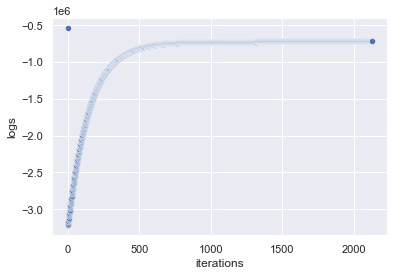

In [29]:
sns.scatterplot(x = 'iterations', y = 'logs', data = data_log)

In [34]:
betas_a0 = []
betas_a1 = []
betas_b0 = []
betas_b1 = []
iterations = []
i = 0

for i in range(0,1000):
    parameter_list = initialize_parameter_list({})
    try:
        new_params, log_likelies = run_em(parameter_list, df)
    except:
        "math error"
    betas_a0.append(new_params['beta_a0'])
    betas_a1.append(new_params['beta_b0'])
    betas_b0.append(new_params['beta_a1'])
    betas_b1.append(new_params['beta_b1'])
    i+= 1
    iterations.append(i)

Text(0.5, 1.0, 'Beta B1')

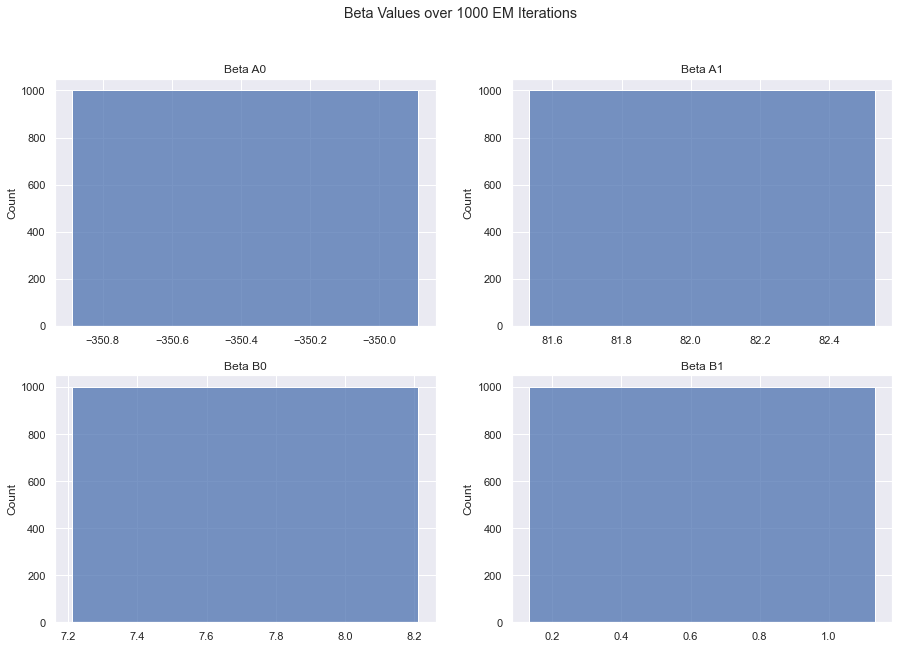

In [35]:
# sns.scatterplot(x = betas_a0, y = iterations)
fig, axes = plt.subplots(2, 2, figsize=(15,10))
fig.suptitle(f'Beta Values over {i} EM Iterations')
sns.histplot(x=betas_a0, ax=axes[0, 0]).set_title('Beta A0')
sns.histplot(x=betas_a1, ax=axes[0, 1]).set_title('Beta A1')
sns.histplot(x=betas_b0, ax=axes[1, 0]).set_title('Beta B0')
sns.histplot(x=betas_b1, ax=axes[1, 1]).set_title('Beta B1')